<a href="https://colab.research.google.com/github/rlsummerschool/practical-sessions/blob/master/notebooks/bandits_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bandit Algorithms

This practical session of [RLSS 2023](https://rlsummerschool.com/) is based on the lectures on Stochastic Multi-Armed Bandits by Emilie Kaufmann ([slides](https://drive.google.com/file/d/1CXrOd8Ltc5x9QmAGmxNWaYmWgZY5V2kJ/view?usp=sharing)) and on Contextual Bandits by Claire Vernade ([slides](https://drive.google.com/file/d/11G6_mvo9DY1nQR3qsZ6X__3TpPTcBFXH/view?usp=sharing)).

It was developed by [Julia Olkhovskaya](https://sites.google.com/view/julia-olkhovskaya/home) and Matteo Papini building upon notebooks by Claire Vernade.

As a motivation for this tutorial, we consider the multiple choice testing for the webpage design problem.

Good design of a webpage is not only about the matching colours and useful
interfaces. Even if one website
design seems to be the most rational for the designer, it is usually hard to
predict which webpage design users will like the most. Therefore, the
important part of the webpage design is the testing on the real users.
Since displaying the webpage with bad design means the loss of the money,
we need to develop a mecanism that chooses the page design that is
the best most of time.
Your objective is to build a desision support system which chooses the website design at each time step without any prior knowledge.

In [2]:
#Set up the environment
!pip install "git+https://github.com/rlsummerschool/practical-sessions.git" --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 22.3 MB/s eta 0:00:00


In [3]:
#A bunch of imports
import numpy as np

from rlss_practice.model import Environment, Agent, MAB_env
import rlss_practice.model
from rlss_practice.display import plot_result


from scipy.stats import bernoulli
from math import log
import random

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-v0_8')

# Multi-Armed Bandits

We formulate the choice design of a webpage design as a multi-armed bandit problem.  We
will use the synthetically generated “visits” of users, for each user the system will recommend the version of the website, so each version of the website is an arm. We model the engagement score (~#clicks) corresponding to the of version of the website as a Gaussian random variable.

## Interaction protocol
Let's recall Emilie's lecture from yesterday. An (adaptive) agent interacts with an unknown environment for $T$ rounds. At each round $t$:

* The agent picks an arm (action) $A_t$ from a set of $K$ actions
* The agent receives a reward $R_t \sim \nu_{A_t}$

where $\nu_{a}$ is an *unknown* distribution with mean $\mu_a$. In our case, it's a Gaussian distribution *with standard deviation $\sigma=1$ for all arms*:

$R_t \sim \mathcal{N}(\mu_a, 1)$

The goal is to maximize total reward $\sum_{t=1}^TR_t$.

Here is some code to play a bandit algorithm (adaptive agent) in a MAB environment, and to compare the performance on different algorithms on the same problem.

In [4]:
#The function play runs one path of regret for one agent:

def play_mab(environment, agent, N, T):
    """
    Play N independent runs of length T for the specified agent.
    Return the agent's name (string) and the collected data in an nd-array.
    """

    rewards = np.zeros((N, T))
    regrets = np.zeros((N, T))
    pseudo_regrets = np.zeros((N, T))
    avg_rewards = np.zeros((N, T))

    for n in range(N):
        agent.reset()
        for t in range(T):
            action = agent.get_action()
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            rewards[n,t] = reward
            # compute instantaneous regret
            means = environment.get_means()
            best_reward = np.max(means)
            regrets[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive
            avg_rewards[n,t] = means[action]
            pseudo_regrets[n,t] = best_reward - means[action]

    return agent.name(), rewards, regrets, avg_rewards, pseudo_regrets


def experiment_mab(environment, agents, N, T, mode="regret"):
    """
    Play N trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, rewards, regrets, avg_rewards, pseudo_regrets = play_mab(environment, agent, N, T)

        if mode == "regret":
            all_data[agent_id] = regrets
        elif mode == "pseudo regret":
            all_data[agent_id] = pseudo_regrets
        elif mode == "reward":
            all_data[agent_id] = rewards
        elif mode == "average reward":
            all_data[agent_id] = avg_rewards
        else:
            raise ValueError

    return all_data

## Multi-Armed Bandit

Our MAB environment has 3 arms (three possible website designs). We will run online algorithms for $T=1000$ steps (corresponding to 1000 users visiting the website in sequence) and average results over $N=50$ independent runs.

In [5]:
K = 3  # number of arms

env = MAB_env(rlss_practice.model.MEANS) #We don't know the reward distributions in advance!

T = 1000  # Horizon
N = 50  # Monte Carlo simulations

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)
#choice of percentile to display
q = 10

### Exercise 1. (Epsilon) Greedy

Let's start with the $\epsilon$-greedy algorithm, where $\epsilon$ is an "exploration" parameter.

The way $\epsilon$-greedy selects actions is

$A_t = \arg\max_{a\in\{1,\dots,K\}} \widehat{\mu}_a(t-1)$ with probability $1-\epsilon$

$A_t \sim \mathrm{Uniform}(1,\dots,K)$ otherwise

Where $\widehat{\mu}_a(t-1)$ is the average reward for arm $a$ up to time $t-1$ included.

You are given an *incomplete* implementation of $\epsilon$-greedy that actually implements the Greedy algorithm ($\epsilon=0$). This code already includes computation of average rewards!

Your task is to:
* Complete the implementation of $\epsilon$-greedy [(hint)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)
* Find a good value of $\epsilon$ for our 3-arms problem
* Compare the regret with Greedy ($\epsilon=0$)

Bonus exercise:
* Implement a version of $\epsilon$-greedy where the exploration parameter changes with time, as seen in Emilie's lecture. Does it work better?

In [6]:
class EpsilonGreedy(Agent):
  def __init__(self, K, eps=0.):
    self.eps = eps # exploration probability
    self.K = K # number of arms
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)

  def get_action(self):
    #SOLUTION:
    u = np.random.random()
    if u<self.eps:
        return np.random.choice(self.K)
    #END SOLUTION

    chosen_arm_index = np.argmax(self.avg_rewards)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm] # update

    self.t += 1

  def name(self):
    return 'EGreedy('+str(self.eps)+')'

First let's see how we can visualize the result of an algorithm, using Greedy as an example

In [7]:
greedy = EpsilonGreedy(K,  eps=0.)

What we can measure **in a real bandit application** is just the rewards of the selected arms! This is the nature of bandit feedback

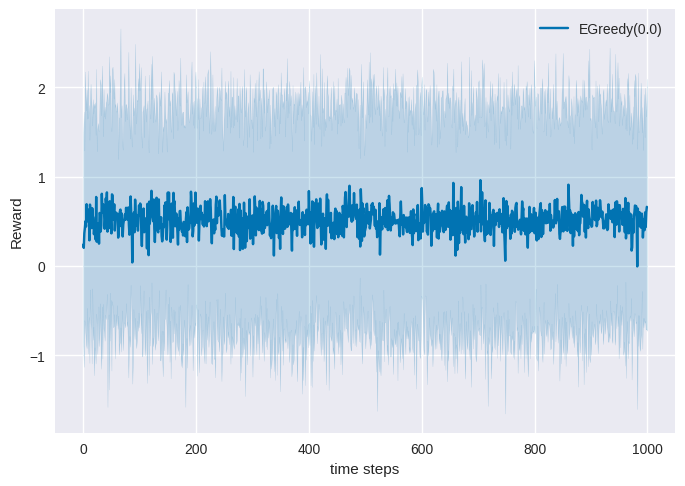

In [8]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="reward")
plot_result(greedy_experiment, q=q, mode="reward", cumulative=False);

For better visualization, we can also sum rewards over time

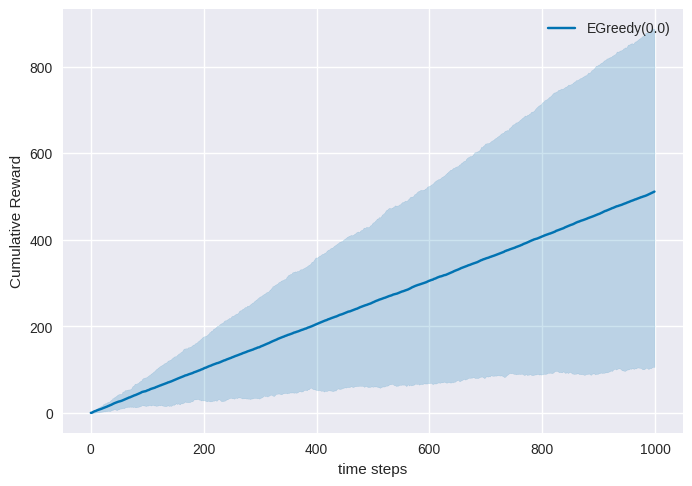

In [9]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="reward")
plot_result(greedy_experiment, q=10, mode="reward", cumulative=True);

In research experiments, we often test algorithms on known distribution. This allows us to compute the (cumulative) regret:

$\mathcal{R}(T) = T\mu_\star - \sum_{t=1}^TR_t$

Of course the agent doesn't have acces to this information, neither would we in a real application.

Remember that **smaller regret is better** when comparing algorithms.

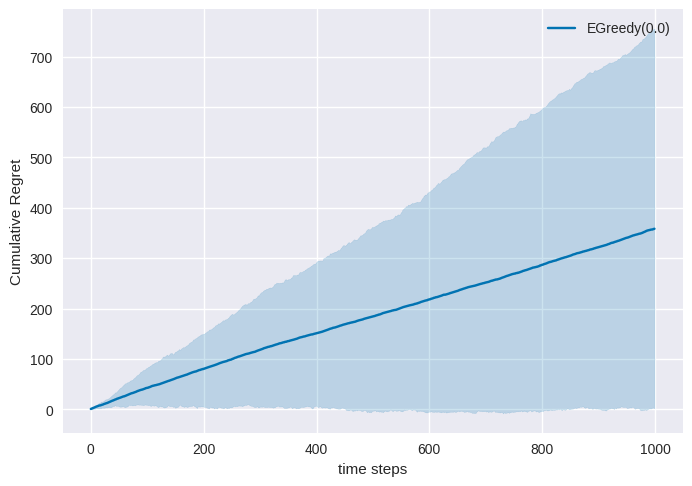

In [10]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="regret")
plot_result(greedy_experiment, q=10, mode="regret");

Finally, we can ignore the noise in the rewards and compute the **pseudo regret** instead (again, only in a controlled experiment):

$\widetilde{\mathcal{R}}(T) = T\mu_\star - \sum_{t=1}^T\mu_{A_t}$

We will use pseudo regret going on.

Note that it is still a random quantity! (can you see why?)

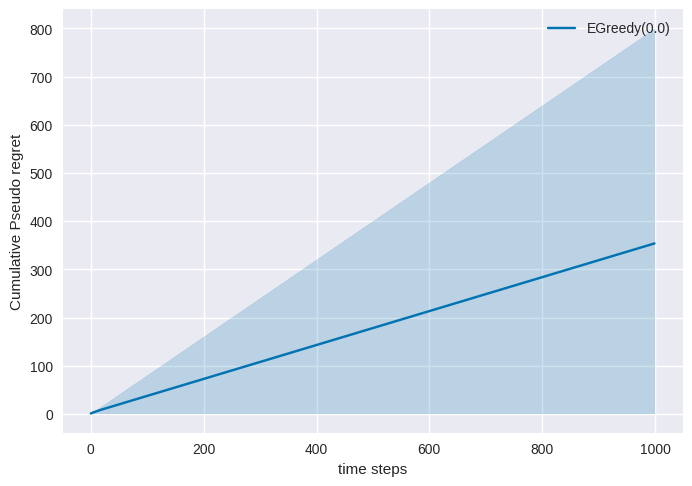

In [11]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="pseudo regret")
plot_result(greedy_experiment, q=10, mode="pseudo regret");

### Now it's time to test you implementation of epsilon greedy!

Remember: whatever bandit algorithm you use in your application, always make sure to compare it with Greedy first. Sometimes, Greedy (supervised learning) is all your client/boss will be willing to deploy...

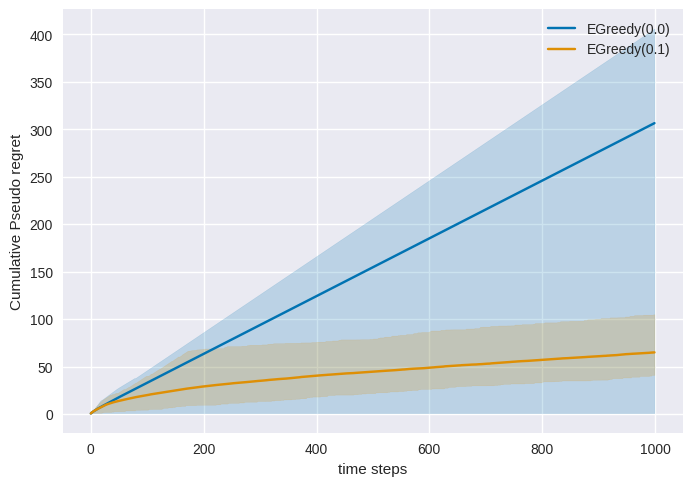

In [12]:
EPSILON = 0.1 #not given

eps_greedy = EpsilonGreedy(K,  eps=EPSILON)

eps_greedy_experiment = experiment_mab(env, [greedy, eps_greedy], N=N, T=T, mode="pseudo regret")
plot_result(eps_greedy_experiment, q=10, mode="pseudo regret");

### Exercise 2. UCB

Now you will have to implement (the action selection rule of) UCB:

**After playing each arm once**

$A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

where the score or *index* of an action is

$F_t(a) = \widehat{\mu}_a(t) + \sqrt{\frac{\alpha \log t}{N_a(t)}}$               

and $N_a(t)$ is the number of times arm $a$ was selected up to time $t$ and $\alpha>0$ is an exploration parameter.

In [13]:
class UCB(Agent):
  def __init__(self, K, alpha):
    self.alpha = alpha
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)


  def get_action(self):
    #TO FILL:
    with np.errstate(divide='ignore'):
        bonuses = np.sqrt(self.alpha * np.log((self.t + 1)) / self.num_played)
    scores = self.avg_rewards + bonuses
    ##END

    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.t += 1

  def name(self):
    return 'UCB('+str(self.alpha)+')'

It's time to test your implementation of UCB!
* Can you find a good value of $\alpha$? Emilie's slides may help
* How does it perform compared to $\epsilon$-greedy?


<ipython-input-13-884c95ca4914>:22: RuntimeWarning: invalid value encountered in true_divide
  bonuses = np.sqrt(self.alpha * np.log((self.t + 1)) / self.num_played)


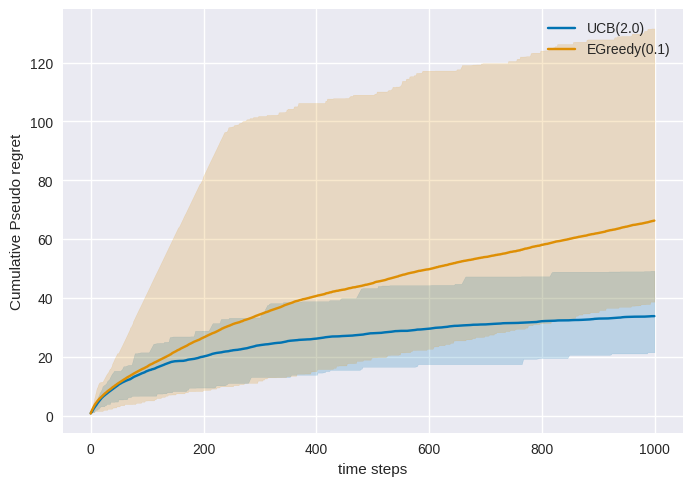

In [14]:
epsilon_greedy = EpsilonGreedy(K,  eps=0.1) #replace with call to solution or remove entirely
ALPHA = 2. #not given
ucb = UCB(K, alpha=ALPHA)
ucb_experiment = experiment_mab(env, [ucb, eps_greedy], N=N, T=T, mode="pseudo regret")
plot_result(ucb_experiment, q=10, mode="pseudo regret");

## Exercise 3. Thompson Sampling

You next task is to implement the action-selection rule of Thompson Sampling (TS).

### tl;dr


* For each arm $a\in\{1,\dots,K\}$ sample $F_{t-1,a} \sim \mathcal{N}\left(\widehat{\mu_a}(t-1), \frac{\sigma^2}{N_a(t-1)}\right)$
* Play $A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$


### Gaussian Thompson Sampling

TS is a *randomized* algorithm. We can still write the selection rule as for index algorithms:

$A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

but now $F_{t}(a)$ is a randomized quantity:

$F_{t}(a) \sim Q_{t,a}$

where $Q_{t,a}$ is a *posterior distribution* obtained by Bayes' rule:

$Q_{t,a}(F) \propto Q_{t-1,a}(F) \cdot P(R_t | F)$

starting from some given *prior* $Q_{0,a}$ and sequentially updating it (only for the chosen arm) with the *likelihood* of observed rewards (separately for each arm)

In our case *we know* the rewards are gaussian with standard deviation $\sigma=1$, so it is natural to use a Gaussian likelihood:

$P(R_t|\mu_a=F) = \mathcal{N}(F,1)$

and a zero-mean Gaussian prior:

$Q_{0,a} = \mathcal{N}(0,1)$ for all $a$.

By Bayes' rule it's easy to show that the posterior is also Gaussian

$Q_{t,a} = \mathcal{N}\left(\widehat{\mu_a}(t-1), \frac{\sigma^2}{N_a(t-1)}\right)$

where $\sigma=1$ in our case. So you can implement the selection rule of Gaussian TS as follows:

* For each arm $a\in\{1,\dots,K\}$ sample $F_{t-1,a} \sim \mathcal{N}\left(\widehat{\mu_a}(t-1), \frac{\sigma^2}{N_a(t-1)}\right)$
* Play $A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

[Hint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)

In [15]:
class ThompsonSampling(Agent):
  def __init__(self, K, sigma=1.):
    self.sigma = sigma #prior std
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)
    self.stds = self.sigma * np.ones(self.K) #TO FILL


  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.stds = self.sigma * np.ones(self.K) #TO FILL

  def get_action(self):
    #TO FILL:
    scores = np.random.normal(self.avg_rewards, self.stds)
    ##END
    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.stds[chosen_arm] = self.sigma / np.sqrt(self.num_played[chosen_arm]) #NOT GIVEN
    self.t += 1

  def name(self):
    return 'TS('+str(self.sigma)+')'

Now it's time to test your implementation of Thompson sampling on our 3-arm bandit problem. Does it perform better than UCB?

<ipython-input-13-884c95ca4914>:22: RuntimeWarning: invalid value encountered in true_divide
  bonuses = np.sqrt(self.alpha * np.log((self.t + 1)) / self.num_played)


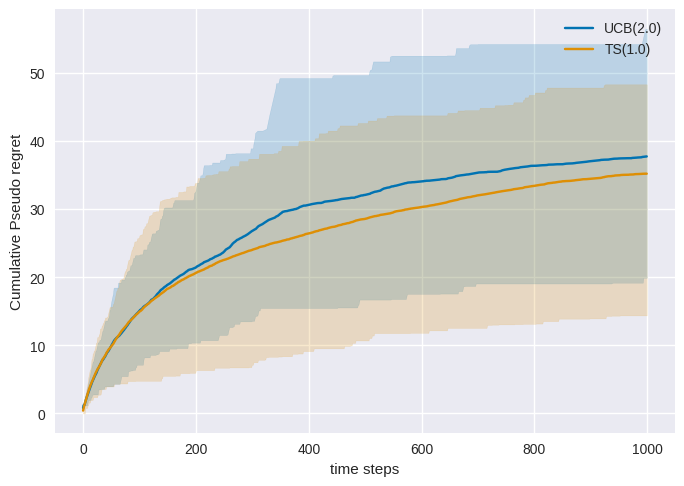

In [16]:
ucb = UCB(K,  alpha=2.) #call solution or remove entirely
ts = ThompsonSampling(K)
ts_experiment = experiment_mab(env, [ucb, ts], N=N, T=T, mode="pseudo regret")
plot_result(ts_experiment, q=10, mode="pseudo regret");

# Linear Contextual Bandits

Coming back to our web application, we now want to develop a *personalised* system, taking into account that differnt users may like different versions of the website. We assume that for each pair of user features $u$ and website version $w$, there is a feature map $\phi(u,w) \in \mathcal{R}^d$, such that the reward (engagement score) we get from user $U_t$ interacting with website version $W_t$ is

$R_t=\phi(U_t,W_t)^\top \theta + \epsilon_t$

where $\epsilon_t \sim  N(0, \sigma^2)$ is just standard normal noise.

This is an instance of the *linear bandit* problem introduced in Claire's lecture. The "actions" are now vectors in $R^d$, representing *contextual features* $X_t = \phi(u_t,w)$, and the environment is assumed to generate rewards according to the unknown linear function $R_t = X_t^\top \theta + \epsilon_t$ (parameter $\theta\in\mathbb{R}^d$ is unknown to the agent)

You can imagine that at each time step $t$ our website compares some features of the user (age, location,...) with some properties of the $K=7$ versions of our webpage and produces $K$ feature vectors in $\mathbb{R}^d$ ($d=3$), representing the presumed "affinity" of the current user with each of the $K$ versions (the actual implementation is greatly simplified)

The underlying assumption is that these feature vectors are expressive enough so that the reward will be a linear function of these known "actions" with the unknown parameter $\theta$

Here is some code to run linear-bandit experiments, similar to the one we have used for MAB

In [17]:
def randomActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    if mean is None:
        mean = np.zeros(d)
    vecs = np.random.multivariate_normal(mean, np.eye(d), size=K)
    norms = np.linalg.norm(vecs,axis=1)
    return vecs / norms[:,np.newaxis]

In [18]:
class LinearBandit(Environment):

    def __init__(self, theta, K, pb_type, var=1., fixed_actions=None):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = np.zeros(self.d)
        self.pb_type = pb_type
        if self.pb_type not in ['fixed', 'iid']:
            raise ValueError(pb_type, "this type of problem is unknown, either change it or define it :)")

        #Now, set up the game for the given type:
        if self.pb_type == 'fixed':
            if fixed_actions is not None:

                self.K, action_dim = fixed_actions.shape #safety reset of self.K in case different
                if action_dim != self.d: # safety check
                    raise ValueError(fixed_actions, "actions dimension and theta mismatch: fix your actions.")
                self.fixed_actions = fixed_actions
            else:
                #create a fixed action set:
                self.fixed_actions = randomActionsGenerator(self.K, self.d)

            self.current_action_set = self.fixed_actions

        elif self.pb_type == 'iid':
            # generate a random set
            self.current_action_set = randomActionsGenerator(self.K, self.d)


    def get_action_set(self):
        if self.pb_type == 'fixed':
            self.current_action_set = self.fixed_actions
            return self.current_action_set
        elif self.pb_type == 'iid':
            self.current_action_set = randomActionsGenerator(self.K, self.d)
            return self.current_action_set


    def get_reward(self, action):

        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        mean = np.dot(action, self.theta)
        return np.random.normal(mean, scale=self.var)

    def get_means(self):
        return np.dot(self.current_action_set, self.theta)

In [19]:
def play_linb(environment, agent, Nmc, T):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """

    data = np.zeros((Nmc, T))


    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            # Note that the main difference with the previous lab is that now get_action needs to receive the action_set
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - np.dot(action, environment.theta) # pseudo regret

    return agent.name(), data


def experiment_linb(environment, agents, Nmc, T):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play_linb(environment, agent,Nmc, T)

        all_data[agent_id] = regrets

    return all_data

In [25]:
d = 3  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized:
theta = np.array([0.45, 0.5, 0.5]) #move to solutions
theta /= np.linalg.norm(theta)

T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations

lin_env = LinearBandit(theta, K, pb_type='iid')

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)
#choice of percentile display
q = 10

### Exercise 4. Linear $\epsilon$-greedy

Your next task is to complete the implementation of the action selection rule of Linear $\epsilon$-greedy. You can reuse some of your code from your implementation of $\epsilon$-greedy for MABs.

The main difference compared to the MAB case is that `get_action` has an input `arms` ($\mathcal{X}_t$ in the pseudocode below) that is the set of $3$-dimensional feature vectors generated by the environment.

The selection rule is:

* Play $X_t = \arg \max_{x \in \mathcal{X}_t} x^T \hat{\theta}_t $ with probability $1-\epsilon$
* Play $X_t$ sampled uniformly at random from $\mathcal{X}_t$ instead

where $\hat{\theta}_t$ is the *least squares estimate* of the unknown parameter $\theta$ based on all the arms played so far and the corresponding collected rewards:

$\widehat{\theta}_t = V_{t}^{-1}b_t$

where $b_t$ is the *target vector*

$b_t=\sum_{s=1}^{t-1}X_{t}R_{t}$

and $V_{t}$ is the $\lambda$-regularized *covariance matrix*

$V_{t}=\lambda I + \sum_{s=1}^{t-1}X_{t}X_{t}^T$

In [26]:
from numpy.linalg import pinv

class LinEpsilonGreedy(Agent):
  def __init__(self, d,lambda_reg=1., eps=0.1,):
    self.eps = eps # exploration probability
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()

  def reset(self):
    self.t = 0
    self.hat_theta = np.zeros(self.d)

    #The covariance matrix is initialized here
    self.cov = self.lambda_reg * np.identity(self.d)

    #The inverse of the covariance matrix is initialized here
    self.invcov = np.identity(self.d)

    #The target vector is initialized here
    self.b_t = np.zeros(self.d)


  def get_action(self, arms):
    K, _ = arms.shape

    #Your code here
    u = np.random.random()
    if u<self.eps:
        return arms[np.random.choice(K)]

    estimated_means = np.dot(arms, self.hat_theta)
    chosen_arm_index = np.argmax(estimated_means)
    #end your code

    return arms[chosen_arm_index,:]

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """

    #Update inverse covariance matrix
    #your code:
    xxt = np.outer(chosen_arm, chosen_arm.T)
    self.cov += xxt
    self.invcov = pinv(self.cov)

    #Update the target vector

    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate

    #end your code
    self.t += 1

  def name(self):
    return 'LinEGreedy('+str(self.eps)+')'

You can test Linear $\epsilon$-greedy here...don't forget to compare it with the greedy version ($\epsilon=0$)

**Bonus exercise:** instead of inverting the covariance matrix at each step, you could update it incrementally using the [Sherman-Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula). You can reuse this trick for LinUCB below (any practical implementation of LinUCB should use this trick!)   

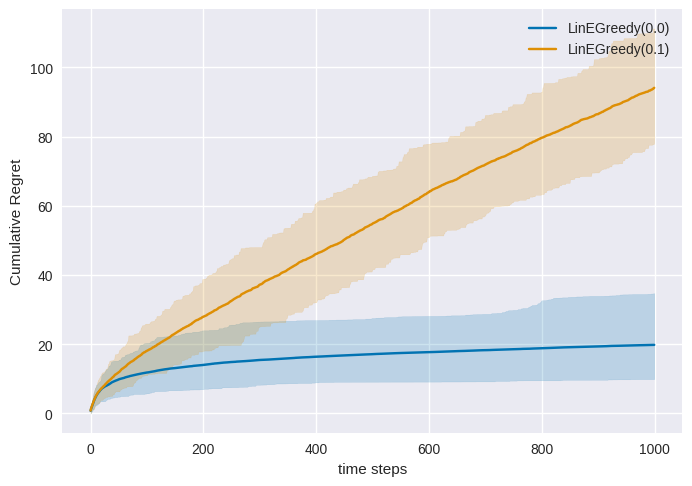

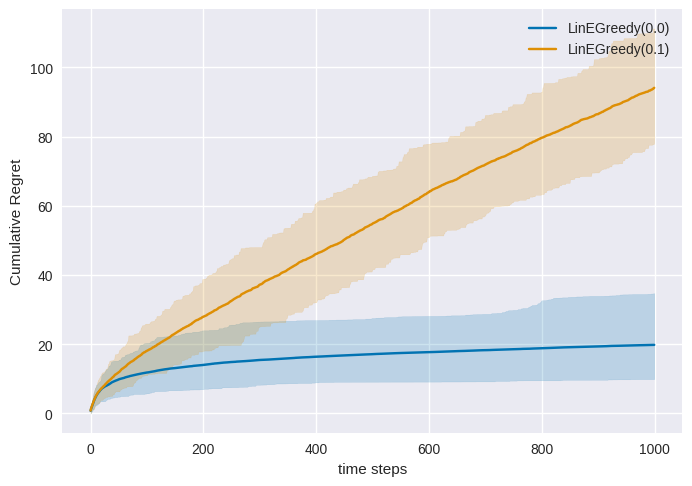

In [28]:
lin_eps_greedy = LinEpsilonGreedy(d, eps=0.1)
lin_greedy = LinEpsilonGreedy(d, eps=0.)
lin_eps_greedy_experiment = experiment_linb(lin_env, [lin_greedy, lin_eps_greedy], Nmc=N, T=T)
plot_result(lin_eps_greedy_experiment)

## Exercise 4. LinUCB --- Implementing optimism in $R^d$

Finally, you can implement LinUCB. You can reuse your implementation of `receive_reward` from `LinEpsilonGreedy`. The selection rule is:

* $F_t(x) = x^T \widehat{\theta_t} + \alpha\beta_t \sqrt{x^T V_t^{-1} x}$

* Play $X_t = \arg\max_x F_t(x)$

where we have already coded the "theoretical" exploration parameter $\beta_t$ for you...but you can use the hyper-parameter $\alpha$ to rescale it (smaller exploration bonuses could work better in practice...)

In [22]:
class LinUCB(Agent):

    def __init__(self, d, delta, lambda_reg=1., alpha=1.):
        self.d = d
        self.delta = delta
        self.lambda_reg = lambda_reg
        self.cov = self.lambda_reg * np.identity(d)


        self.alpha = alpha
        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted
        self.t = 0
        self.hat_theta = np.zeros(self.d)
        self.cov = self.lambda_reg * np.identity(self.d)
        self.invcov = np.identity(self.d)
        self.b_t = np.zeros(self.d)


    def get_action(self, arms):
        """
            This function implements LinUCB
            Input:
            -------
            arms : list of arms (d-dimensional vectors)

            Output:
            -------
            chosen_arm : vector (chosen arm array of features)
            """
        # compute the UCB of each of the arm in arms, here arms are vectors
        #     ucbs = np.array(K)

        #     for i in range(K):
        #         ucbs[i] = 1# use hat_theta and beta and the covariance matrix. beta_n is the upper bound given at the very end of the class

        K, _ = arms.shape
        self.UCBs = np.zeros(K)
        self.beta = np.sqrt(self.lambda_reg) + np.sqrt(2*np.log(1./self.delta) + np.log(1+self.t/(self.d*self.lambda_reg)))  #sqrt(beta)

        for i in range(K):
            a = arms[i,:]
            covxa = np.inner(self.invcov, a.T)
            #add your code
            self.UCBs[i] = np.dot(
                self.hat_theta,a) +  self.alpha * self.beta * np.sqrt(np.dot(a, covxa))
            #end your code

        chosen_arm_index = np.argmax(self.UCBs)
        chosen_arm = arms[chosen_arm_index]
        return chosen_arm


    def receive_reward(self, chosen_arm, reward):
       #start your code
        xxt = np.outer(chosen_arm, chosen_arm.T)
        self.cov += xxt
        self.invcov = pinv(self.cov)

        self.b_t += reward * chosen_arm

        self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate

        #end your code
        self.t += 1

        pass


    def name(self):
        return "LinUCB("+str(self.alpha)+')'

# Question: Is LinUCB better than the baseline LinEpsilonGreedy?
Compare the two methods on both environments and conclude. In light of the above example, decide which values of epsilon you want to try in your comparisons and explain your choices following the suggested template.

In [ ]:
# policies

linucb = LinUCB(d, delta)
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)

In [ ]:
linucb_vs_greedy = experiment_linb(iid_env, [greedy, e_greedy, linucb], Nmc=N, T=T)

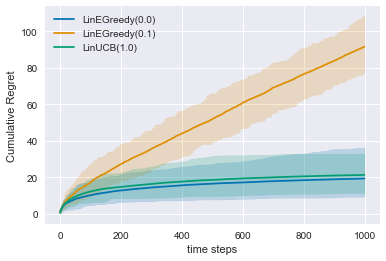

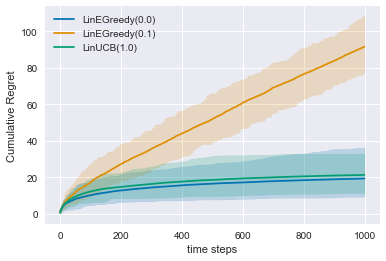

In [ ]:
plot_result(linucb_vs_greedy)

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions.

* **Posterior derivation**: Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\lambda I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ?

The posterior is
$$
p(\theta|A_1,Y_1,\ldots,A_t,Y_t) \propto p(A_1,Y_1,\ldots,A_t,Y_t|\theta)p(\theta) \sim \mathcal{N}(\hat{\theta}_t, V^{-1}_t)
$$
A nice way to see this is via the maximum likelihood problem (see https://perso.telecom-paristech.fr/bonald/documents/bandit.pdf) or via the traditional Bayesian posterior derivations for Gaussians with known variance (see https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/slides/lec19-slides.pdf)

So to implement LinTS, one has to sample from the posterior a *hallucinated* parameter $\tilde{\theta}$ and then use this parameter to evaluate the mean of each arm in the action set at round $t$. Note that the sampling step *replaces* the bonus in LinUCB.


* **Implementation of a LinTS (Linear Thompson Sampling) agent**.

In [ ]:
class LinTS(Agent):

  def __init__(self, d, delta, lambda_prior):
    self.d = d
    self.delta = delta
    self.lambda_prior = lambda_prior
    self.cov = self.lambda_prior * np.identity(d)
    self.reset()

  def reset(self):
    # reset all local variables that should not be kept when the experiment is restarted
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_prior * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)


  def get_action(self, arms):
    """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : vector (chosen arm array of features)
        """

    K, _ = arms.shape
    estimated_means = np.zeros(K)

    #your code starts here:
    hallucinated_theta = np.random.multivariate_normal(self.hat_theta, self.invcov)
    #ends here

    for i in range(K):
        estimated_means[i] = np.dot(hallucinated_theta,arms[i,:])


    #choose arm with largest estimated mean
    chosen_arm_index = np.argmax(estimated_means)
    chosen_arm = arms[chosen_arm_index]


    return chosen_arm



  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    xxt = np.outer(chosen_arm, chosen_arm.T)
    self.cov += xxt
#     self.invcov = pinv(self.cov)
    self.invcov = pinv(self.cov)

    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
    self.t += 1

    pass


  def name(self):
    return "LinTS"

# Is Thompson Sampling better than LinUCB?
Compare these two policies in all environments and conclude.

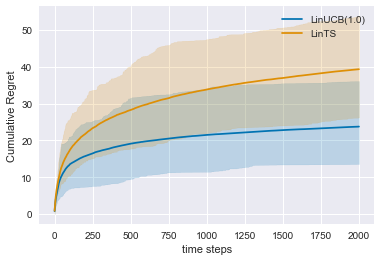

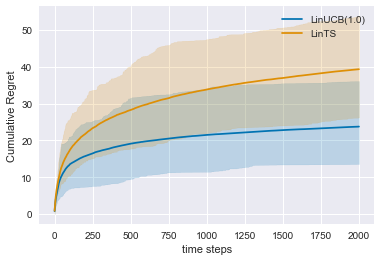

In [ ]:
T=2000
N=50

linucb.reset()
ts = LinTS(d, delta, lambda_prior=1.)

linucb_vs_ts = experiment_linb(iid_env, [linucb, ts], Nmc=N, T=T)

plot_result(linucb_vs_ts, q=10)